# Librerías

In [29]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import math

# Preprocesamiento de datos de entrada

In [48]:
# preparaing data
df_train = pd.read_csv('train.csv')

df_train['Pclass'] = df_train['Pclass'].astype(str)

df_train = pd.concat([df_train, pd.get_dummies(df_train[['Pclass', 'Sex', 'Embarked']])], axis=1)

# I will fill missings with the median
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())

df_train['is_child'] = df_train['Age'].map(lambda x: 1 if x < 12 else 0)
cols_model = ['is_child', 'Pclass_1', 'Pclass_2', 'Sex_female']


# División de datos de entrenamiento y datos de prueba

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_train[cols_model], df_train['Survived'], test_size=0.10, random_state=42, stratify=df_train['Survived'])

X_train = np.array(X_train.values, requires_grad=False)
Y_train = np.array(y_train.values * 2 - np.ones(len(y_train)), requires_grad=False)

# Etapa del Feacture Map

In [ ]:
num_qubits = 4
num_layers = 4
dev = qml.device("default.qubit", wires=num_qubits)

In [33]:
# quantum circuit functions
def statepreparation(x):
    qml.BasisEmbedding(x, wires=range(0, num_qubits))


# Etapa del Ansatz

In [34]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

@qml.qnode(dev, interface="autograd")
def circuit(weights, x):
    statepreparation(x)
    qml.layer(layer, num_layers, weights)
    return qml.expval(qml.PauliZ(0))

In [35]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

# Etapa de Funcion de pérdida

In [36]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss


# Etapa de evaluación de la Función de Costo

In [37]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

# Etapa de Análisis de Precisión

In [38]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

# Pesos iniciales definidos

In [39]:
# setting init params
np.random.seed(0)
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [40]:
print(weights_init)

[[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]

 [[ 0.02269755 -0.01454366  0.00045759]
  [-0.00187184  0.01532779  0.01469359]
  [ 0.00154947  0.00378163 -0.00887786]
  [-0.01980796 -0.00347912  0.00156349]]

 [[ 0.01230291  0.0120238  -0.00387327]
  [-0.00302303 -0.01048553 -0.01420018]
  [-0.0170627   0.01950775 -0.00509652]
  [-0.00438074 -0.01252795  0.0077749 ]]]


# Entrenamiento

In [41]:
from pennylane.optimize import GradientDescentOptimizer
opt = GradientDescentOptimizer(stepsize=0.2)
num_it = 70
batch_size = math.floor(len(X_train)/num_it)

In [42]:
weights = weights_init
bias = bias_init
for it in range(num_it):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_train]
    acc = accuracy(Y_train, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X_train, Y_train), acc
        )
    )

Iter:     1 | Cost: 2.4333636 | Accuracy: 0.3121099 
Iter:     2 | Cost: 2.3754800 | Accuracy: 0.3121099 
Iter:     3 | Cost: 2.3580234 | Accuracy: 0.3121099 
Iter:     4 | Cost: 2.5711820 | Accuracy: 0.6167291 
Iter:     5 | Cost: 2.6159762 | Accuracy: 0.6167291 
Iter:     6 | Cost: 2.2987764 | Accuracy: 0.3121099 
Iter:     7 | Cost: 2.2042082 | Accuracy: 0.3121099 
Iter:     8 | Cost: 2.0648117 | Accuracy: 0.3121099 
Iter:     9 | Cost: 1.8101951 | Accuracy: 0.6779026 
Iter:    10 | Cost: 1.5649428 | Accuracy: 0.6167291 
Iter:    11 | Cost: 1.4446011 | Accuracy: 0.6167291 
Iter:    12 | Cost: 1.2217857 | Accuracy: 0.5842697 
Iter:    13 | Cost: 1.0710824 | Accuracy: 0.6167291 
Iter:    14 | Cost: 0.9992195 | Accuracy: 0.6816479 
Iter:    15 | Cost: 0.9561990 | Accuracy: 0.6204744 
Iter:    16 | Cost: 0.9432681 | Accuracy: 0.5855181 
Iter:    17 | Cost: 0.8862277 | Accuracy: 0.5855181 
Iter:    18 | Cost: 0.8181127 | Accuracy: 0.6891386 
Iter:    19 | Cost: 0.8236089 | Accuracy: 0.72

# Pesos Finales entrenados

In [46]:
print(weights)

[[[ 0.01764052 -0.37454776  0.00407995]
  [ 0.02240893  1.03516881 -0.00288499]
  [ 0.00950088  0.47145696 -0.00157036]
  [ 0.00410599 -0.45985561  0.01427182]]

 [[ 0.00692708  0.39423713  0.00807251]
  [ 0.01379999  0.7763355   0.01032205]
  [ 0.00472335 -0.03807762 -0.02395986]
  [ 0.00340854 -0.94034211 -0.00661974]]

 [[ 0.01093496 -0.2840666  -0.01459447]
  [-0.00533594  1.02193497  0.01116749]
  [-0.00381233  0.10323143 -0.01553119]
  [-0.01038925  0.24815016  0.01171036]]

 [[ 0.01230291  0.0120238  -0.00387327]
  [-0.00309629 -0.21442389 -0.01420018]
  [-0.01510299  0.61667931 -0.00509652]
  [-0.00969959 -1.11785856  0.0077749 ]]]


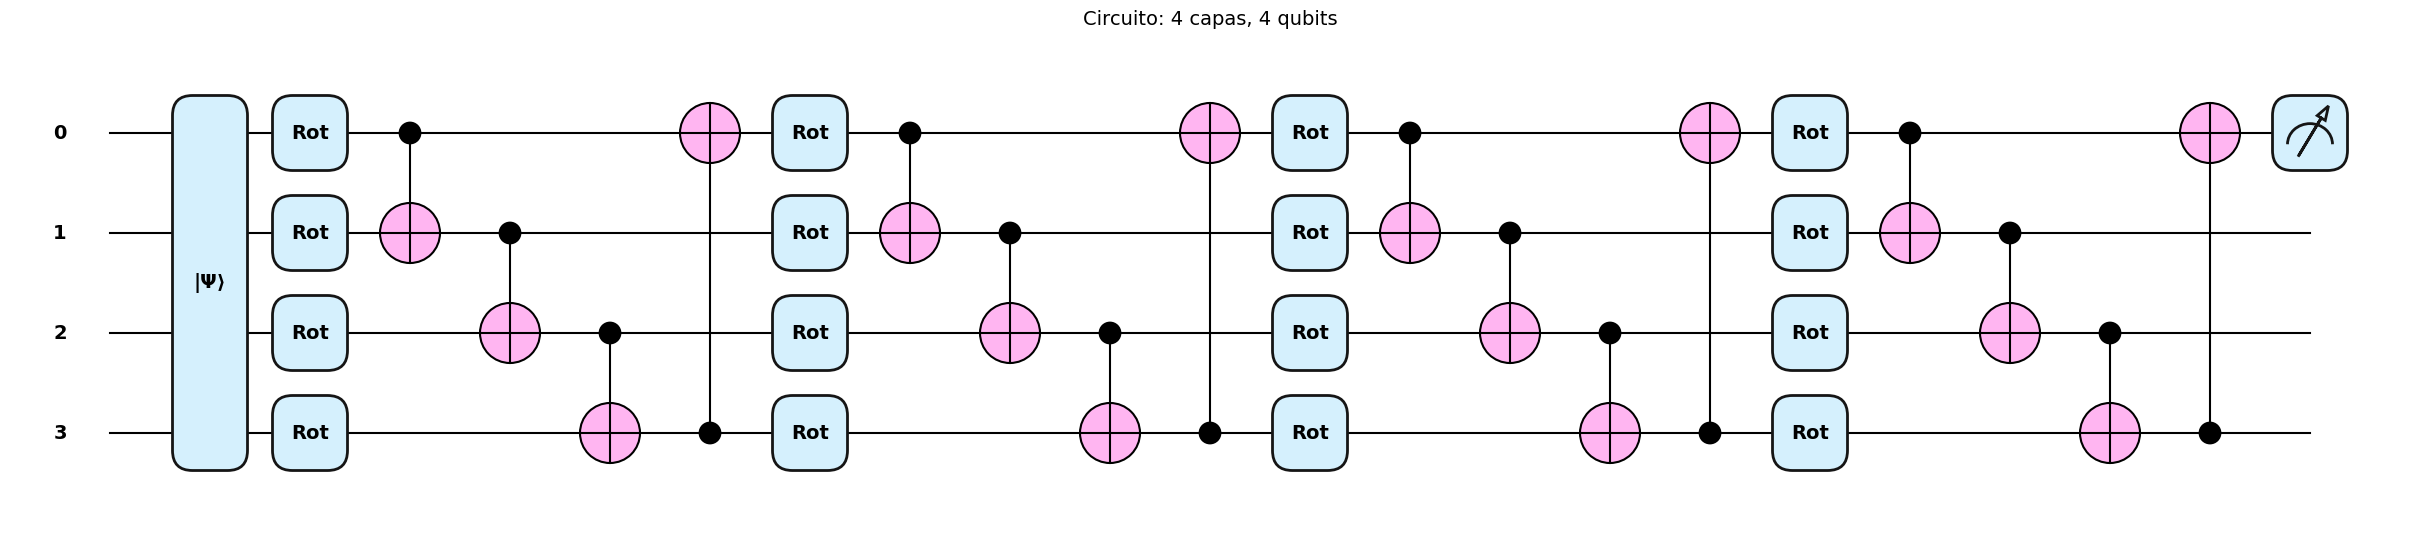

In [53]:
# Quantum circuit represented by Pennylane
import matplotlib.pyplot as plt
qml.drawer.use_style("pennylane")

fig, ax = qml.draw_mpl(circuit)(weights, X_train[0])
ax.set_title("Circuito: 4 capas, 4 qubits", fontsize=14)
plt.show()



# Evaluación de desempeño del clasificador cuántico final.

In [50]:
X_test = np.array(X_test.values, requires_grad=False)
Y_test = np.array(y_test.values * 2 - np.ones(len(y_test)), requires_grad=False)

predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]


In [54]:
accuracy_score(Y_test, predictions)
precision_score(Y_test, predictions)
recall_score(Y_test, predictions)
f1_score(Y_test, predictions, average='macro')

0.7025240384615383

# Entrenamiento:   Accuracy 0.7903
# Datos de prueba: Accuracy 0.7025

\begin{array}{|c|c|c|} \hline
VQC & Accuracy-Train & Accuracy-Test\\ \hline
Original & 0.7840 & 0.7712  \\
Modificado & 0.7903 & 0.7025 \\
\hline
\end{array}

No fue suficiente con cambiar el optimizador y el Ansatz. Toco hacer varias pruebas porque la precision se quedo estancado en un valor: 

Iter:     1 | Cost: 2.7272563 | Accuracy: 0.3121099 

Iter:     2 | Cost: 2.7104982 | Accuracy: 0.3121099 

Iter:     3 | Cost: 2.6985930 | Accuracy: 0.3121099 

Iter:     4 | Cost: 2.6554103 | Accuracy: 0.3121099

Iter:     5 | Cost: 2.6306309 | Accuracy: 0.3121099

Iter:     6 | Cost: 2.6289993 | Accuracy: 0.3121099 

Iter:     7 | Cost: 2.6237349 | Accuracy: 0.3121099

Iter:     8 | Cost: 2.6221877 | Accuracy: 0.3121099 

Iter:     9 | Cost: 2.5994570 | Accuracy: 0.3121099

Iter:    10 | Cost: 2.5882040 | Accuracy: 0.3121099 

Iter:    11 | Cost: 2.5742026 | Accuracy: 0.3121099 

Iter:    12 | Cost: 2.5736959 | Accuracy: 0.3121099 

Muy posible del optimizador se quedo en un minimimo local o se ajustan lentamente.

Entonces se aumento del numero de capas de 2 a 4: **num_layers = 4**

Se probaron varios valores de pasos del optimizador: 00.1, 0.05, 0.125 pero al final el que mejor funciono es el de: 

**GradientDescentOptimizer(stepsize=0.2)**

El Ansatz solo se cambio por el qml.layer(), es otra forma de hacer el mismo bucle de for W in weights: layer(W), por lo tanto da el mismo circuito cuantico y GradientDescentOptimizer es un poco más simple que el AdamOptimizer, este ultimo es más robusto. 

Como se observa en la tabla final de resultados, vemos que el VQC modificado tuvo mejor precision en el entrenamiento pero menos en el test, eso quiere decir que tiene mejor generalizacion el original que este modificado, puede ser varias razones, como el optimizador es un poco más sencillo que el que tiene originalmente. Pero de todas formas ambos modelos estan entre 70 y 80 % de precision que es lo minimo que se le puede pedir a un modelo de machine learning en general. 